### Data preprocessing

- spatial domain: global land
- temporal domain: 1950-01-01 - 2014-12-31

| var  | dims | path |
| ---  | ---  | ---  |
| **input vars** |
| Rainf  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Rainf/' |
| Snowf  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Snowf/' |
| SWdown  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/SWdown/' |
| LWdown  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/LWdown/' |
| Tair  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Tair/' |
| Wind  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Wind/' |
| Qair  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Qair/' |
| PSurf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/PSurf/' |
| lai | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_lai.nc' |
| ccover | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_ccover.nc' |
| PFT | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_PFT.nc' |
| soil_properties | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_soil_propreties.nc' |
| **target vars**
| et (also input) | lat, lon, time (per year) | '/workspace/BGI/work_2/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_YYYY.nc' |
| tws  | lat, lon, time (per year) | '/workspace/BGI/work_2/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_YYYY.nc' |
| mrlsl_shal  | lat, lon, time  (per year), levelc (mean top 4) | '/workspace/BGI/work_2/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_YYYY.nc' |
| mrlsl_deep  | lat, lon, time  (per year), levelc (mean below 4th layer) | '/workspace/BGI/work_2/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_YYYY.nc' |


The datasets are first harmonized and copyed to local storage in NetCDF format, then, all datasets are combined into one zarr file and data attributes are updated.

In [13]:
import xarray as xr
import zarr
from dask.diagnostics import ProgressBar
import numpy as np
import sys
import os
import shutil
import ray

sys.path.append('/workspace/bkraft/dl_chapter14/src')
from utils.plotting import plot_map, subplots_robinson, plot_scatter, plot_hist2d, plot_hexbin
from utils.parallel import parcall

# Configuration

In [2]:
data_store = '/scratch/dl_chapter14/data/'
netcdf_store = os.path.join(data_store, 'netcdf')
zarr_store = os.path.join(data_store, 'data.zarr')
years = np.arange(1980, 2013+1)
date_slice = slice(f'{years[0]}-01-01', f'{years[-1]}-12-31')

if not os.path.isdir(netcdf_store):
    os.makedirs(netcdf_store)

# Functions

In [3]:
def harmonize_ds(ds):
    """Select proper date range and calculate mean of leveled datasets.
    
    * Renames 'longitude' and 'latitude' for 'lon' and 'lat'

    Parameters
    ----------
    ds:    xr.Dataset

    """
    
    if 'latitude' in ds:
        ds = ds.rename(latitude='lat')
    if 'longitude' in ds:
        ds = ds.rename(longitude='lon')
    if 'soil_propreties' in ds:
        ds = ds.rename(soil_propreties='soil_properties')

    varnames = ds.data_vars
    ds = ds.rename({var: var.lower() for var in varnames})

    if ds.lat[0] < ds.lat[1]:
        ds = ds.reindex(lat=list(reversed(ds.lat)))

    return ds

def chunk_ds(ds):
    chunks = {'lat': 10, 'lon': 10}
    if 'time' in ds:
        chunks.update({'time': -1})
    ds = ds.chunk(chunks)
    return ds

def get_encoding(ds):
    return {var: {'compressor': None} for var in ds.data_vars}

def zarr_rm_array(store, var):
    store = zarr.open(zarr_store, mode='r+')
    if var in store:
        store.store.rmdir(var)

def stack_time(files_in, var, zarr_store, mode='a'):
    """Stack multiple datasets along time dimension.

    Parameters
    ----------
    files_in        List of netcdf file paths.
    zarr_store      Zarr store to append the array to.
    mode            'w' to create a new group, 'a' to append (default).

    """

    zarr_rm_array(zarr_store, var.lower())
    ds = xr.open_mfdataset(
        files_in, parallel=True, preprocess=harmonize_ds,
        combine='by_coords')
    ds = chunk_ds(ds)
    ds.to_zarr(zarr_store, mode=mode, encoding=get_encoding(ds))

def matsiro_preproc(ds, var):
    """Select proper date range and calculate mean of leveled datasets.
    
    * Removes the 366th date from non-leap-years, as this is encoded as
      next year's 1st of January.
    * For the variable 'mrlslfrac', the mean of the first 4 layers
      is calculated.

    Parameters
    ----------
    ds:    xr.Dataset
    var:   str, variable to elect

    """
    year = ds.time.values[0].astype('datetime64[Y]').astype(int) + 1970
    data_slice = slice(f'{year}-01-01', f'{year}-12-31')

    if var == 'mrlsl_shal':
        ds[var] = ds['mrlsl'].isel(levelc=slice(0, 4)).sum('levelc')
    if var == 'mrlsl_deep':
        ds[var] = ds['mrlsl'].isel(levelc=slice(4, 13)).sum('levelc')

    ds = ds[[var]].sel(time=data_slice)
    ds = harmonize_ds(ds)
    
    return ds

def combine_matsiro(files_in, file_out, var, mode='a'):
    zarr_rm_array(zarr_store, var)
    ds = xr.open_mfdataset(files_in, preprocess=lambda x: matsiro_preproc(x, var), parallel=True, combine='by_coords')
    ds = chunk_ds(ds)
    ds.to_zarr(zarr_store, mode=mode, encoding=get_encoding(ds))

# MATSIRO inputs

Other model inputs not contained in GSWP3

#### Processing steps

Copy to local storage

In [4]:
basedir = '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/'
varnames = ['lai', 'ccover', 'PFT', 'soil_propreties']
files = {
    var: os.path.join(basedir, f'matsiro-gw_{var}.nc') for var in varnames
}

In [5]:
# Create the zarr store by writing a first file.
lai = files.pop('lai')

ds = xr.open_dataset(lai).sel(time=date_slice)
ds = harmonize_ds(ds)
ds = chunk_ds(ds)

with ProgressBar():
    ds.to_zarr(zarr_store, mode='w', encoding=get_encoding(ds))

# Create zarr using first dataset.


[########################################] | 100% Completed |  8min  8.8s


In [6]:
# For all further datasets, we append to the existing zarr store.
for i, (k, v) in enumerate(files.items()):
    print(f'{i+1:2d} / {len(files)}')
    ds = xr.open_dataset(v)
    if 'time' in ds:
        ds = ds.sel(time=date_slice)
    ds = harmonize_ds(ds)
    ds = chunk_ds(ds)

    zarr_rm_array(zarr_store, k)
    
    with ProgressBar():
        ds.to_zarr(zarr_store, mode='a', encoding=get_encoding(ds))

 1 / 3
[########################################] | 100% Completed |  9min 15.5s
 2 / 3
[########################################] | 100% Completed |  5.1s
 3 / 3
[########################################] | 100% Completed |  5.3s


# MATSIRO outputs

#### processing steps

Extract from multi-varaible NetCDF file, stack time, harmonize data (non-leap years have empty last time-step each year) and copy to local storage. For the variable *mrlslfrac*, calculate mean of top four layers.

In [7]:
varnames = ['mrlsl_shal', 'mrlsl_deep', 'et', 'mrro', 'tws']

In [8]:
matsiro_paths = {
    var: {
        'files_in': [
            f'/workspace/BGI/work_2/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_{y}.nc'
            for y in years],
        'file_out': os.path.join(netcdf_store, f'{var}.nc'),
        'var': var
    } for var in varnames
}

In [9]:
parcall(combine_matsiro, matsiro_paths, num_cpus=5, ray_init_kwargs={'object_store_memory': 40e9}, mode='a')

2019-12-20 18:19:27,865	INFO resource_spec.py:205 -- Starting Ray with 327.0 GiB memory available for workers and up to 37.25 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


2019-12-20 18:19:27 - Parallel execution of function `combine_matsiro` using 5 CPUs with 5 total runs.
2019-12-20 18:33:48 - Done, elapsed time: 14 m 21 s (2 m 52 s per call).


[None, None, None, None, None]

# GSWP3

http://hydro.iis.u-tokyo.ac.jp/GSWP3/

#### Processing steps

Stack data and copy to local disc to improve speed of further processing steps

In [10]:
gswp_dir = '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/'
gswp_vars = ['Rainf', 'Snowf', 'SWdown', 'LWdown', 'Tair', 'Wind', 'Qair', 'PSurf']

#### Stack data and copy to local disc

In [11]:
gswp_paths = {}
for var in gswp_vars:
    gswp_paths.update({
        var: {
            'files_in': [os.path.join(gswp_dir, var, f'{var}.{y}.nc') for y in years],
            'var': var
        }
    })

In [12]:
# Stack years and copy to local storage. This takes some hours to run!
parcall(stack_time, gswp_paths, num_cpus=1, zarr_store=zarr_store, ray_init_kwargs={'memory': 500e9, 'object_store_memory': 250e9})

2019-12-20 18:33:48,933	INFO resource_spec.py:205 -- Starting Ray with 465.62 GiB memory available for workers and up to 232.83 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


2019-12-20 18:33:48 - Parallel execution of function `stack_time` using 1 CPUs with 8 total runs.
(pid=1449) /opt/conda/lib/python3.6/site-packages/xarray/core/dataset.py:1616: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
(pid=1449)   append_dim=append_dim,
(pid=1449) /opt/conda/lib/python3.6/site-packages/xarray/core/dataset.py:1616: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
(pid=1449)   append_dim=append_dim,
(pid=1449) /opt/conda/lib/python3.6/site-packages/xarray/core/dataset.py:1616: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
(pid=1449)   append_dim=append_dim,
(pid=1449) /opt/conda/lib/python3.6/site-packages/xarray/core/dataset.py:1616: SerializationWarning: saving variable None with floating point data as an integer dtype without a

[None, None, None, None, None, None, None, None]

# Fix coordinates (shifted)

In [13]:
s_zr = zarr.open(zarr_store, mode='r+')

In [14]:
s_zr.lat[:] = xr.open_dataset(gswp_paths['SWdown']['files_in'][0]).latitude.values
s_zr.lon[:] = xr.open_dataset(gswp_paths['SWdown']['files_in'][0]).longitude.values

# Add attributes do zarr

* Add global attributes
* Add missing long_name and unit attribute if missing
* Add mean and std as attribute

In [15]:
s_xr = xr.open_zarr(zarr_store)
s_zr = zarr.open(zarr_store, 'r+')

In [16]:
global_attrs = {
    'processed_by': 'bkraft@bgc-jena.mpg.de',
    'data_source': 'GSWP and MATSIRO (skoirala@bgc-jena.mpg.de)',
    'description': 'GSWP and MATSIRO data data cube.'
}
missing_data_attrs = {
    'ccover': {
        'long_name': 'cloud cover',
        'units': 'fraction'
    },
    'lai': {
        'long_name': 'leaf area index',
        'units': 'm2/m2'
    },
    'pft': {
        'long_name': 'plant functional type',
        'units': '-'
    },
    'soil_properties': {
        'long_name': 'soil properties',
        'units': '-'
    },
    'mrlsl_shal': {
        'long_name': 'soil moisture content <=150mm',
        'units': 'm3/m3'
    },
    'mrlsl_deep': {
        'long_name': 'soil moisture content >150mm',
        'units': 'm3/m3'
    },
    'time': {
        'long_name': 'time'
    },
    'lat': {
        'long_name': 'latitude',
        'units': 'degree'
    },
    'lon': {
        'long_name': 'longitude',
        'units': 'degree'
    },
    'mask': {
        'long_name': 'data mask',
        'units': '-'
    }
}

In [17]:
s_zr.attrs.put(global_attrs)

In [18]:
for var in s_xr.data_vars:
    print(var)
    ds = s_xr[var]
    if 'time' in ds.dims:
        mean = ds.sel(time=slice('2000-01-01', '2000-12-31')).mean().compute()
        std = ds.sel(time=slice('2000-01-01', '2000-12-31')).std().compute()
    else:
        mean = ds.mean().compute()
        std = ds.std().compute()
    if var in missing_data_attrs.keys():
        s_zr[var].attrs.update(missing_data_attrs[var])
    s_zr[var].attrs.update({
        'mean': float(mean.values),
        'std': float(std.values),
        'long_name': s_zr[var].attrs['long_name'].lower()
    })

ccover


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


et


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


lai


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


lwdown
mrlsl_deep
mrlsl_shal
mrro


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


pft


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


psurf
qair
rainf
snowf
soil_properties


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


swdown
tair
tws


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


wind


In [19]:
for var in s_xr.dims:
    ds = s_xr[var]
    if var in missing_data_attrs.keys():
        s_zr[var].attrs.update(missing_data_attrs[var])

# Get mask of valid pixels

In [20]:
time_vars = []
non_time_vars = []
for var in s_xr.data_vars:
    if 'time' in s_xr[var].dims:
        time_vars.append(var)
    else:
        non_time_vars.append(var)

In [21]:
mask = s_xr[non_time_vars].to_array().notnull().all('variable').compute()

In [22]:
mask *= ((s_xr.rainf.groupby('time.year').sum('time') + s_xr.snowf.groupby('time.year').sum('time')).mean('year') > 250).compute()

In [23]:
for var in time_vars:
    print(var)
    mask *= s_xr[var].notnull().all('time').compute()

ccover
et
lai
lwdown
mrlsl_deep
mrlsl_shal
mrro
psurf
qair
rainf
snowf
swdown
tair
tws
wind


In [24]:
data_mask = xr.Dataset({'mask': mask})
data_mask.attrs = {
    'long_name': 'data mask',
    'unit': '-'
}

In [25]:
data_mask.astype(int).to_zarr(zarr_store, mode='a')

# Check datacube

In [26]:
import matplotlib.pyplot as plt

In [27]:
s_xr = xr.open_zarr(zarr_store)

In [28]:
s_xr.data_vars

Data variables:
    ccover           (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    et               (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    lai              (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    lwdown           (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    mask             (lat, lon) int64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    mrlsl_deep       (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    mrlsl_shal       (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    mrro             (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    pft              (lat, lon) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    psurf            (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
 

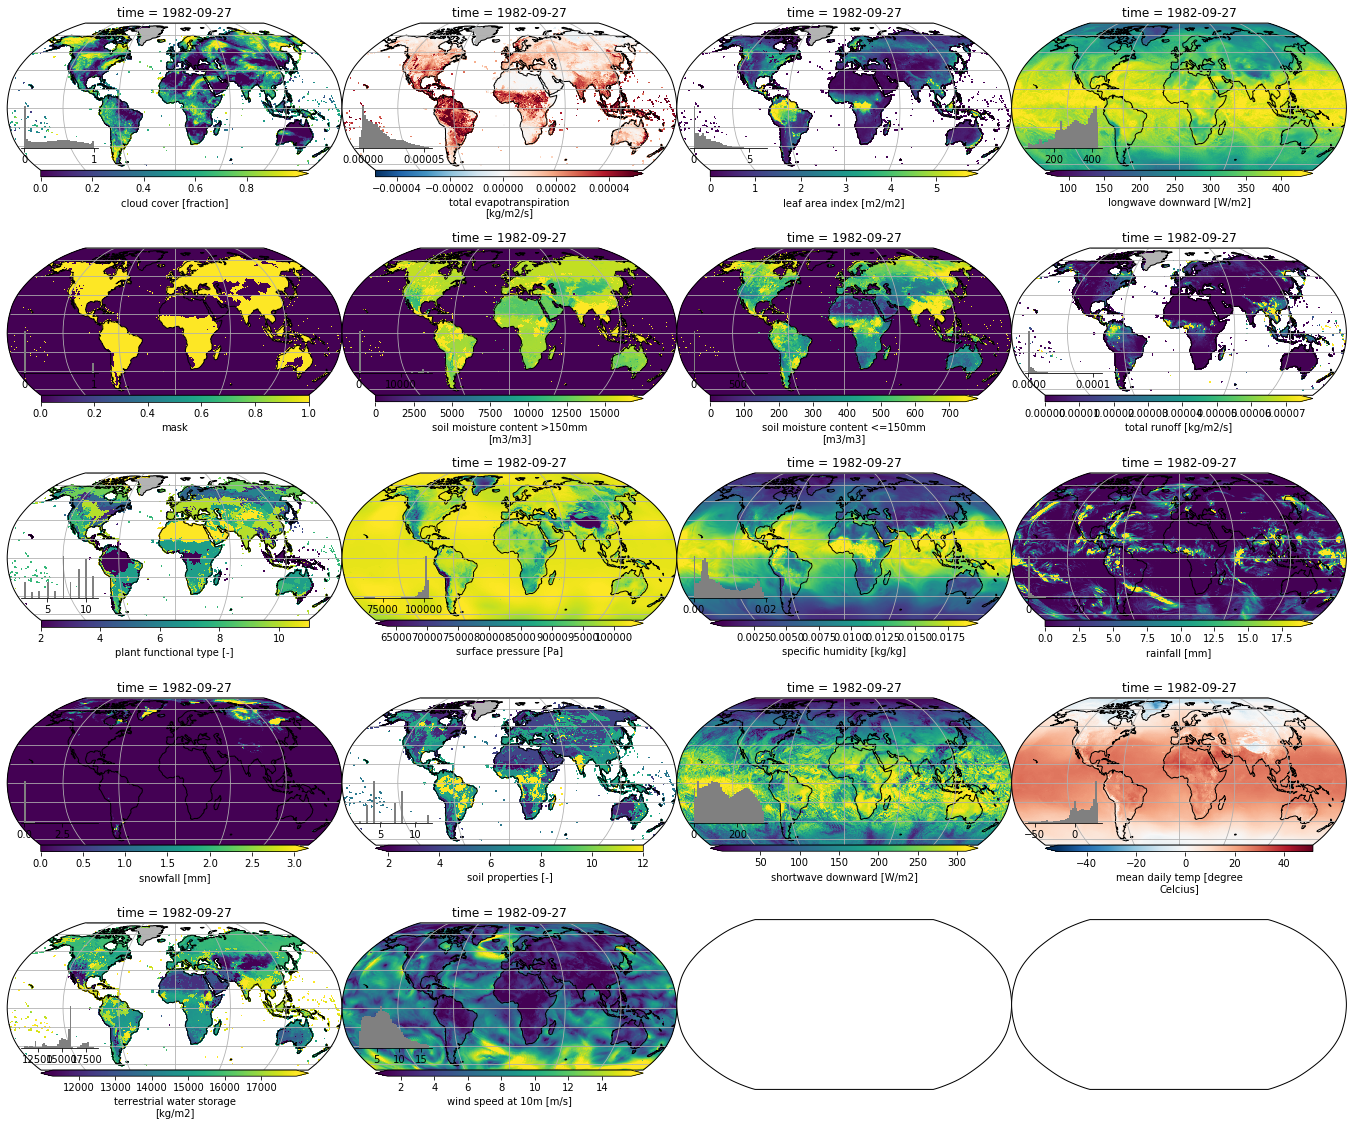

In [29]:
fig, axes = subplots_robinson(5, 4, figsize=(24, 20), gridspec_kw={'wspace': 0, 'hspace': 0.2})
for i, var in enumerate(s_xr.data_vars):
    ax = axes.flat[i]
    if 'time' in s_xr[var].dims:
        ds = s_xr[var].isel(time=1000)
    else:
        ds = s_xr[var]

    # ds = (ds - ds.attrs['mean']) / ds.attrs['std']
    plot_map(ds, robust=True, ax=ax)

In [30]:
!du -h --block-size=GB '/scratch/dl_chapter14/data/'

13GB	/scratch/dl_chapter14/data/data.zarr/snowf
13GB	/scratch/dl_chapter14/data/data.zarr/et
1GB	/scratch/dl_chapter14/data/data.zarr/time
13GB	/scratch/dl_chapter14/data/data.zarr/mrlsl_shal
1GB	/scratch/dl_chapter14/data/data.zarr/pft
13GB	/scratch/dl_chapter14/data/data.zarr/rainf
13GB	/scratch/dl_chapter14/data/data.zarr/ccover
13GB	/scratch/dl_chapter14/data/data.zarr/qair
13GB	/scratch/dl_chapter14/data/data.zarr/lwdown
13GB	/scratch/dl_chapter14/data/data.zarr/mrlsl_deep
1GB	/scratch/dl_chapter14/data/data.zarr/lat
13GB	/scratch/dl_chapter14/data/data.zarr/tair
13GB	/scratch/dl_chapter14/data/data.zarr/wind
1GB	/scratch/dl_chapter14/data/data.zarr/soil_properties
13GB	/scratch/dl_chapter14/data/data.zarr/lai
13GB	/scratch/dl_chapter14/data/data.zarr/mrro
13GB	/scratch/dl_chapter14/data/data.zarr/swdown
13GB	/scratch/dl_chapter14/data/data.zarr/tws
13GB	/scratch/dl_chapter14/data/data.zarr/psurf
1GB	/scratch/dl_chapter14/data/data.zarr/lon
1GB	/scratch/dl_chapter14/data/data.zarr

In [15]:
ds = xr.open_zarr('/scratch/dl_chapter14/data/data.zarr/')
ds

<xarray.Dataset>
Dimensions:          (lat: 360, lon: 720, time: 12419)
Coordinates:
  * lat              (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon              (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time             (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2013-12-31
Data variables:
    ccover           (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    et               (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    lai              (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    lwdown           (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    mask             (lat, lon) int64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    mrlsl_deep       (time, lat, lon) float32 dask.array<chunksize=(12419, 10, 10), meta=np.ndarray>
    mrlsl_shal       (time, lat, lon) float32 dask.array<chunksize=(124

In [45]:
s = ds.soil_properties

In [53]:
min_class = int(s.min().compute())
max_class = int(s.max().compute())
num_classes = max_class - min_class + 1
print(min_class, ' - ', max_class, f'({num_classes})')

/opt/conda/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/opt/conda/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


1  -  12 (12)


In [56]:
def one_hot(val, min_class, num_class):
    enc = np.zeros(num_class, dtype=np.float32)
    enc[val-min_class] = 1
    return enc

In [70]:
np.stack([one_hot(1, 0, 3), one_hot(0, 0, 3)], axis=0).shape

(2, 3)

In [72]:
np.concatenate([one_hot(1, 0, 3), one_hot(0, 0, 3)]).shape

(6,)

In [73]:
torch.cat()

In [76]:
ds.soil_properties.min().compute()

/opt/conda/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


<xarray.DataArray 'soil_properties' ()>
array(1., dtype=float32)

In [78]:
ds.soil_properties.max().compute()

/opt/conda/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


<xarray.DataArray 'soil_properties' ()>
array(12., dtype=float32)

In [82]:
np.nanmin(ds.pft)

2.0

In [80]:
ds.pft.max().compute()

/opt/conda/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


<xarray.DataArray 'pft' ()>
array(11., dtype=float32)